<a href="https://colab.research.google.com/github/Ruwai/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=298.1775818295259, mobile=True), User(purchased=False, time_on_site=190.92586446459734, mobile=True), User(purchased=True, time_on_site=71.05217746597023, mobile=True), User(purchased=False, time_on_site=129.28780191724897, mobile=True), User(purchased=False, time_on_site=122.50337342826313, mobile=False), User(purchased=False, time_on_site=376.3266668111279, mobile=False), User(purchased=False, time_on_site=149.28958181042913, mobile=True), User(purchased=False, time_on_site=126.66604001726554, mobile=True), User(purchased=False, time_on_site=292.9297051927087, mobile=True), User(purchased=False, time_on_site=52.2108904211212, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,298.177582,True
1,False,190.925864,True
2,True,71.052177,True
3,False,129.287802,True
4,False,122.503373,False


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.121524492698447,6.179352773867927,6.19986803285029,7.428230654354032,7.985219934100924,8.287016165556526,8.57927295353635,8.925359932718454,9.013512316112841,9.203737402264842,...,586.7812193106183,587.2096551409725,589.0285617925759,590.707146336302,591.3970858941199,593.5239446695506,595.4960776024598,597.839526695479,599.2789923399588,599.5323177791358
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,0,0,0,1,...,1,1,1,1,1,0,1,1,1,1
True,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.527, 124.004]","(124.004, 242.886]","(242.886, 361.768]","(361.768, 480.65]","(480.65, 599.532]"
purchased,,,,,
False,269,300,147,57,42
True,72,67,34,5,7


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.527, 124.004]","(124.004, 242.886]","(242.886, 361.768]","(361.768, 480.65]","(480.65, 599.532]"
purchased,,,,,
False,0.788856,0.817439,0.812155,0.919355,0.857143
True,0.211144,0.182561,0.187845,0.080645,0.142857


In [8]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.864,0.798667
True,0.136,0.201333


In [9]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
series = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = series

for b in user_data.bin.unique():
  print(user_data[user_data.bin == b].head())

    purchased  time_on_site  mobile                 bin
0       False    298.177582    True  (242.886, 361.768]
8       False    292.929705    True  (242.886, 361.768]
14      False    292.974652    True  (242.886, 361.768]
44      False    270.219526    True  (242.886, 361.768]
45      False    286.088883   False  (242.886, 361.768]
    purchased  time_on_site  mobile                 bin
1       False    190.925864    True  (124.004, 242.886]
3       False    129.287802    True  (124.004, 242.886]
6       False    149.289582    True  (124.004, 242.886]
7       False    126.666040    True  (124.004, 242.886]
10      False    158.241559   False  (124.004, 242.886]
    purchased  time_on_site  mobile               bin
2        True     71.052177    True  (4.527, 124.004]
4       False    122.503373   False  (4.527, 124.004]
9       False     52.210890    True  (4.527, 124.004]
15      False    119.870988    True  (4.527, 124.004]
18      False     58.664087    True  (4.527, 124.004]
    

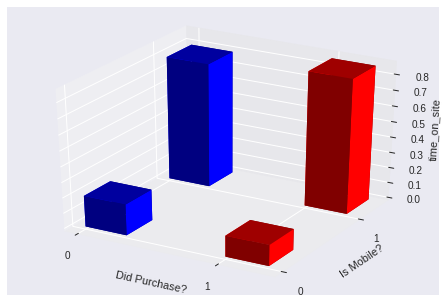

In [10]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [11]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
df = pd.read_csv('/content/drive/My Drive/data/persons.csv')
df

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182
5,5,58,103,165
6,6,55,161,107
7,7,21,188,37
8,8,55,216,79
9,9,50,127,267


In [13]:
from collections import namedtuple

person = namedtuple('person', ['age', 'weight', 'exercise_time'])
ex_person = person(18, 130, 200)

print(ex_person)

person(age=18, weight=130, exercise_time=200)


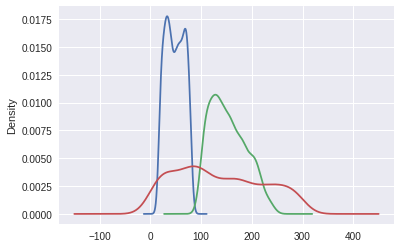

In [14]:
for col in ['age', 'weight', 'exercise_time']:
  df[col].plot.density()

In [0]:
# pd.crosstab(df['exercise_time'],df['weight'], normalize='columns')

In [16]:
time_bins = pd.cut(df['exercise_time'], 10)
ab = pd.crosstab(df['age'], time_bins)
ab

exercise_time,"(-0.3, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
age,,,,,,,,,,
18,1,1,3,3,2,2,2,4,1,1
19,3,2,4,4,1,2,2,3,2,0
20,1,1,3,1,0,3,3,1,2,2
21,0,2,0,2,2,4,1,5,1,1
22,1,3,3,2,4,2,3,1,0,0
23,3,1,2,2,4,3,1,3,1,1
24,1,2,2,1,2,3,2,1,1,2
25,2,2,0,2,1,1,3,3,3,2
26,0,1,1,2,2,0,2,1,4,2


In [17]:
bc = pd.crosstab(df['weight'], time_bins)
bc

exercise_time,"(-0.3, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
weight,,,,,,,,,,
100,3,2,1,0,0,1,2,2,1,3
101,0,0,1,0,1,1,3,2,1,1
102,1,0,2,0,2,1,0,3,1,3
103,1,0,1,1,0,2,0,0,0,3
104,1,1,1,1,1,0,0,2,1,1
105,3,0,0,0,0,2,1,0,1,3
106,0,1,0,2,0,2,1,0,1,1
107,0,0,1,1,2,2,2,1,2,0
108,0,1,2,0,3,3,2,2,3,3


In [18]:
weight_bins = pd.cut(df['weight'], 5)
cd = pd.crosstab(df['age'], weight_bins)
cd

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
18,7,8,3,2,0
19,4,7,6,5,1
20,6,4,5,2,0
21,5,5,6,2,0
22,4,9,3,2,1
23,9,5,2,5,0
24,6,4,4,1,2
25,7,7,2,1,2
26,3,9,2,1,0


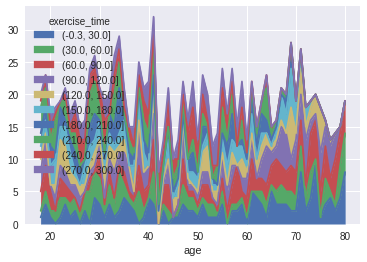

In [19]:
ab.plot.area();

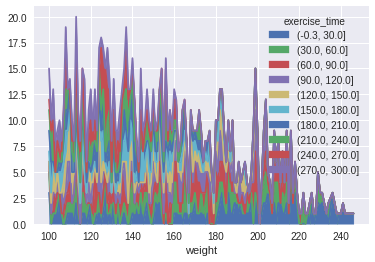

In [20]:
bc.plot.area();

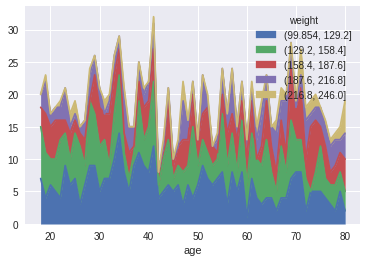

In [21]:
cd.plot.area();

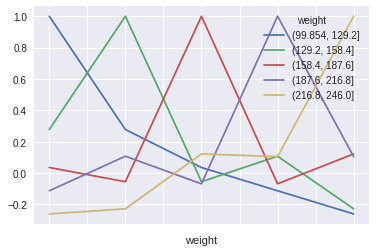

In [22]:
cd_corr = cd.corr(method='pearson')
cd_corr.plot()

In [0]:
### going to make bigger bins 
new_weight_bin = pd.cut(df['weight'], 10)
new_time_bin = pd.cut(df['exercise_time'], 20)
new_age_bin = pd.cut(df['age'], 2)

#making age bin to fit

# time_age_cross = pd.crosstab(new_age_bin, new_time_bin, normalize='columns')

In [24]:
extend_crosstab = pd.crosstab(new_time_bin, [new_weight_bin, new_age_bin], 
                              rownames = ['time_bins'], colnames=['weight', 'age'],
                              normalize='index')
extend_crosstab

weight         (99.854, 114.6]              (114.6, 129.2]               \
age             (17.938, 49.0] (49.0, 80.0] (17.938, 49.0] (49.0, 80.0]   
time_bins                                                                 
(-0.3, 15.0]          0.014925     0.074627       0.000000     0.059701   
(15.0, 30.0]          0.024390     0.073171       0.036585     0.060976   
(30.0, 45.0]          0.027397     0.041096       0.054795     0.054795   
(45.0, 60.0]          0.053571     0.089286       0.089286     0.017857   
(60.0, 75.0]          0.025974     0.090909       0.038961     0.025974   
(75.0, 90.0]          0.045977     0.034483       0.103448     0.011494   
(90.0, 105.0]         0.034483     0.057471       0.034483     0.034483   
(105.0, 120.0]        0.046154     0.015385       0.076923     0.169231   
(120.0, 135.0]        0.065217     0.086957       0.065217     0.043478   
(135.0, 150.0]        0.084746     0.152542       0.101695     0.033898   
(150.0, 165.0]        0.131148     0.049180       0.081967     0.065574   
(165.0, 180.0]        0.105263     0.052632       0.017544     0.122807   
(180.0, 195.0]        0.100000     0.033333       0.133333     0.083333   
(195.0, 210.0]        0.205882     0.088235       0.088235     0.088235   
(210.0, 225.0]        0.142857     0.081633       0.163265     0.102041   
(225.0, 240.0]        0.142857     0.040816       0.122449     0.061224   
(240.0, 255.0]        0.200000     0.000000       0.222222     0.088889   
(255.0, 270.0]        0.090909     0.054545       0.290909     0.127273   
(270.0, 285.0]        0.159091     0.136364       0.159091     0.045455   
(285.0, 300.0]        0.255319     0.063830       0.255319     0.085106   

weight         (129.2, 143.8]              (143.8, 158.4]               \
age            (17.938, 49.0] (49.0, 80.0] (17.938, 49.0] (49.0, 80.0]   
time_bins                                                                
(-0.3, 15.0]         0.014925     0.044776       0.044776     0.029851   
(15.0, 30.0]         0.060976     0.024390       0.024390     0.085366   
(30.0, 45.0]         0.013699     0.041096       0.054795     0.027397   
(45.0, 60.0]         0.071429     0.035714       0.035714     0.017857   
(60.0, 75.0]         0.038961     0.077922       0.051948     0.064935   
(75.0, 90.0]         0.045977     0.103448       0.057471     0.126437   
(90.0, 105.0]        0.022989     0.034483       0.068966     0.057471   
(105.0, 120.0]       0.015385     0.061538       0.046154     0.076923   
(120.0, 135.0]       0.086957     0.065217       0.065217     0.065217   
(135.0, 150.0]       0.033898     0.033898       0.050847     0.050847   
(150.0, 165.0]       0.147541     0.114754       0.049180     0.114754   
(165.0, 180.0]       0.035088     0.052632       0.192982     0.035088   
(180.0, 195.0]       0.116667     0.050000       0.100000     0.050000   
(195.0, 210.0]       0.088235     0.117647       0.117647     0.058824   
(210.0, 225.0]       0.142857     0.081633       0.163265     0.040816   
(225.0, 240.0]       0.183673     0.040816       0.102041     0.102041   
(240.0, 255.0]       0.200000     0.022222       0.066667     0.044444   
(255.0, 270.0]       0.163636     0.018182       0.127273     0.090909   
(270.0, 285.0]       0.159091     0.068182       0.136364     0.113636   
(285.0, 300.0]       0.106383     0.148936       0.042553     0.042553   

weight         (158.4, 173.0]              (173.0, 187.6]               \
age            (17.938, 49.0] (49.0, 80.0] (17.938, 49.0] (49.0, 80.0]   
time_bins                                                                
(-0.3, 15.0]         0.029851     0.074627       0.029851     0.059701   
(15.0, 30.0]         0.012195     0.060976       0.036585     0.073171   
(30.0, 45.0]         0.095890     0.054795       0.027397     0.095890   
(45.0, 60.0]         0.071429     0.053571       0.071429     0.035714   
(60.0, 75.0]         0.012987     0.129870       0.05

In [25]:
group_df = df.groupby(['age','weight'])['exercise_time']
group_df

In [29]:
groups = dict(list(group_df))
groups
#not sure what just happened

{(18, 102): 906    224
 Name: exercise_time, dtype: int64, (18, 114): 83    104
 Name: exercise_time, dtype: int64, (18, 115): 469    243
 Name: exercise_time, dtype: int64, (18, 116): 1108    199
 Name: exercise_time, dtype: int64, (18, 120): 203    161
 Name: exercise_time, dtype: int64, (18, 122): 18    271
 Name: exercise_time, dtype: int64, (18, 126): 840    79
 Name: exercise_time, dtype: int64, (18, 135): 744    156
 Name: exercise_time, dtype: int64, (18, 138): 171    235
 655    213
 Name: exercise_time, dtype: int64, (18, 140): 830     31
 1080    63
 Name: exercise_time, dtype: int64, (18, 141): 622    122
 Name: exercise_time, dtype: int64, (18, 148): 1045    182
 Name: exercise_time, dtype: int64, (18, 150): 754    119
 Name: exercise_time, dtype: int64, (18, 161): 294    85
 Name: exercise_time, dtype: int64, (18, 171): 323    217
 Name: exercise_time, dtype: int64, (18, 184): 372    119
 Name: exercise_time, dtype: int64, (18, 188): 573    128
 Name: exercise_time, dtype

In [30]:
grouped_data = df.groupby(df['exercise_time'])
grouped_data

In [31]:
for key,group in grouped_data:
  print(key)
  print(group)

0
     Unnamed: 0  age  weight  exercise_time
89           89   32     205              0
425         425   20     183              0
1
      Unnamed: 0  age  weight  exercise_time
172          172   58     199              1
998          998   41     242              1
1116        1116   63     144              1
1195        1195   47     195              1
2
      Unnamed: 0  age  weight  exercise_time
65            65   31     231              2
67            67   72     207              2
129          129   79     165              2
331          331   49     216              2
471          471   73     160              2
996          996   72     230              2
1096        1096   59     100              2
3
     Unnamed: 0  age  weight  exercise_time
130         130   24     236              3
162         162   46     219              3
371         371   61     105              3
393         393   51     120              3
569         569   63     233              3
720        

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

The variable types in the data are all integers
age is represented as an integer
weight is represented as an integer
exercise time is represented as an integer in minutes

2.  What are the relationships between the variables?

There are many interpretable relationships between the variables.
The relationships can be seen with the crosstab and correlation tables as well as the plots.
In summary, the relationship between the amount of time you exercise and how much you weigh, is less insightful of having some type of correlation(even though there is a correlation), than how much you wieght and how old you are.
This can be shown with the crosstab table of age and weight, where it is indicated that there are more people who weigh less in the dataset, if they are younger.

3.  Which relationships are "real", and which spurious?

Well in my opinion I believe that all relationships from the data are justifiable given appropriate context. But if there had to be a relationship that was the most "real" and the most spurious, then I would say that the "real" one would be derived from age and weight as previously mentioned in the summary from question 2. And the spurious relationship would be how much time you exercise and how old you are, because that relationship would create a confounding variable.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)